Dataset shape: (4424, 37)

Processing all_features...
Epoch 1/50
80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4482 - loss: 1.2781  
Epoch 1: val_accuracy improved from -inf to 0.71893, saving model to best_all_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4547 - loss: 1.2659 - val_accuracy: 0.7189 - val_loss: 0.8721 - learning_rate: 0.0010
Epoch 2/50
62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6135 - loss: 0.9398
Epoch 2: val_accuracy improved from 0.71893 to 0.72316, saving model to best_all_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 0.9361 - val_accuracy: 0.7232 - val_loss: 0.7658 - learning_rate: 0.0010
Epoch 3/50
66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.6641 - loss: 0.8478
Epoch 3: val_accuracy did not improve from 0.72316
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.8453 - val_accuracy: 0.7090 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 4/50
64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.6643 - loss: 0.7892
Epoch 4: val_accuracy improved from 0.72316 to 0.72881, saving model to best_all_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6648 - loss: 0.7943 - val_accuracy: 0.7288 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 5/50
62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.7137 - loss: 0.7433
Epoch 5: val_accuracy improved from 0.72881 to 0.75000, saving model to best_all_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7104 - loss: 0.7450 - val_accuracy: 0.7500 - val_loss: 0.6158 - learning_rate: 0.0010
Epoch 6/50
52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.7095 - loss: 0.7361
Epoch 6: val_accuracy improved from 0.75000 to 0.75989, saving model to best_all_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7084 - loss: 0.7423 - val_accuracy: 0.7599 - val_loss: 0.5880 - learning_rate: 0.0010
Epoch 7/50
65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7264 - loss: 0.6977
Epoch 7: val_accuracy did not improve from 0.75989
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7252 - loss: 0.7006 - val_accuracy: 0.7542 - val_loss: 0.6066 - learning_rate: 0.0010
Epoch 8/50
62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.7350 - loss: 0.6684
Epoch 8: val_accuracy did not improve from 0.75989
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7348 - loss: 0.6725 - val_accuracy: 0.7444 - val_loss: 0.5958 - learning_rate: 0.0010
Epoch 9/50
59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.7420 - loss: 0.6806
Epoch 9: val_accuracy did not improve from 0.75989
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7416 - loss: 0.6759 - val_accuracy: 0.7500 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 10/50
62/89 ━━━━━━━━━━━━━━━

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4761 - loss: 1.2467 - val_accuracy: 0.7020 - val_loss: 0.8598 - learning_rate: 0.0010
Epoch 2/50
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.6603 - loss: 0.8745
Epoch 2: val_accuracy did not improve from 0.70198
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6607 - loss: 0.8735 - val_accuracy: 0.6977 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.6637 - loss: 0.8154
Epoch 3: val_accuracy improved from 0.70198 to 0.71893, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6638 - loss: 0.8155 - val_accuracy: 0.7189 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 4/50
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.6930 - loss: 0.8122
Epoch 4: val_accuracy did not improve from 0.71893
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6932 - loss: 0.8115 - val_accuracy: 0.7175 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 5/50
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.6997 - loss: 0.7659
Epoch 5: val_accuracy improved from 0.71893 to 0.74294, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7002 - loss: 0.7650 - val_accuracy: 0.7429 - val_loss: 0.6140 - learning_rate: 0.0010
Epoch 6/50
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.7174 - loss: 0.7322
Epoch 6: val_accuracy did not improve from 0.74294
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7172 - loss: 0.7323 - val_accuracy: 0.7359 - val_loss: 0.6039 - learning_rate: 0.0010
Epoch 7/50
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.7150 - loss: 0.7231
Epoch 7: val_accuracy improved from 0.74294 to 0.74435, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7150 - loss: 0.7232 - val_accuracy: 0.7444 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 8/50
83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7170 - loss: 0.7193
Epoch 8: val_accuracy improved from 0.74435 to 0.75000, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7176 - loss: 0.7186 - val_accuracy: 0.7500 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 9/50
82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.7193 - loss: 0.6946
Epoch 9: val_accuracy improved from 0.75000 to 0.75565, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7197 - loss: 0.6942 - val_accuracy: 0.7556 - val_loss: 0.5931 - learning_rate: 0.0010
Epoch 10/50
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.7306 - loss: 0.7005
Epoch 10: val_accuracy improved from 0.75565 to 0.75847, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7307 - loss: 0.7002 - val_accuracy: 0.7585 - val_loss: 0.5825 - learning_rate: 0.0010
Epoch 11/50
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.7409 - loss: 0.6667
Epoch 11: val_accuracy improved from 0.75847 to 0.77260, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7409 - loss: 0.6666 - val_accuracy: 0.7726 - val_loss: 0.5785 - learning_rate: 0.0010
Epoch 12/50
83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.7363 - loss: 0.6724
Epoch 12: val_accuracy did not improve from 0.77260
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7361 - loss: 0.6717 - val_accuracy: 0.7698 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 13/50
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.7400 - loss: 0.6775
Epoch 13: val_accuracy improved from 0.77260 to 0.77401, saving model to best_selected_features.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7401 - loss: 0.6773 - val_accuracy: 0.7740 - val_loss: 0.5759 - learning_rate: 0.0010
Epoch 14/50
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.7529 - loss: 0.6602
Epoch 14: val_accuracy did not improve from 0.77401
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7526 - loss: 0.6602 - val_accuracy: 0.7712 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 15/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.7625 - loss: 0.6477
Epoch 15: val_accuracy did not improve from 0.77401
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7624 - loss: 0.6476 - val_accuracy: 0.7684 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 16/50
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.7607 - loss: 0.6418
Epoch 16: val_accuracy did not improve from 0.77401
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.7606 - loss: 0.6416 - val_accuracy: 0.7571 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 17/50
85/89 ━━━

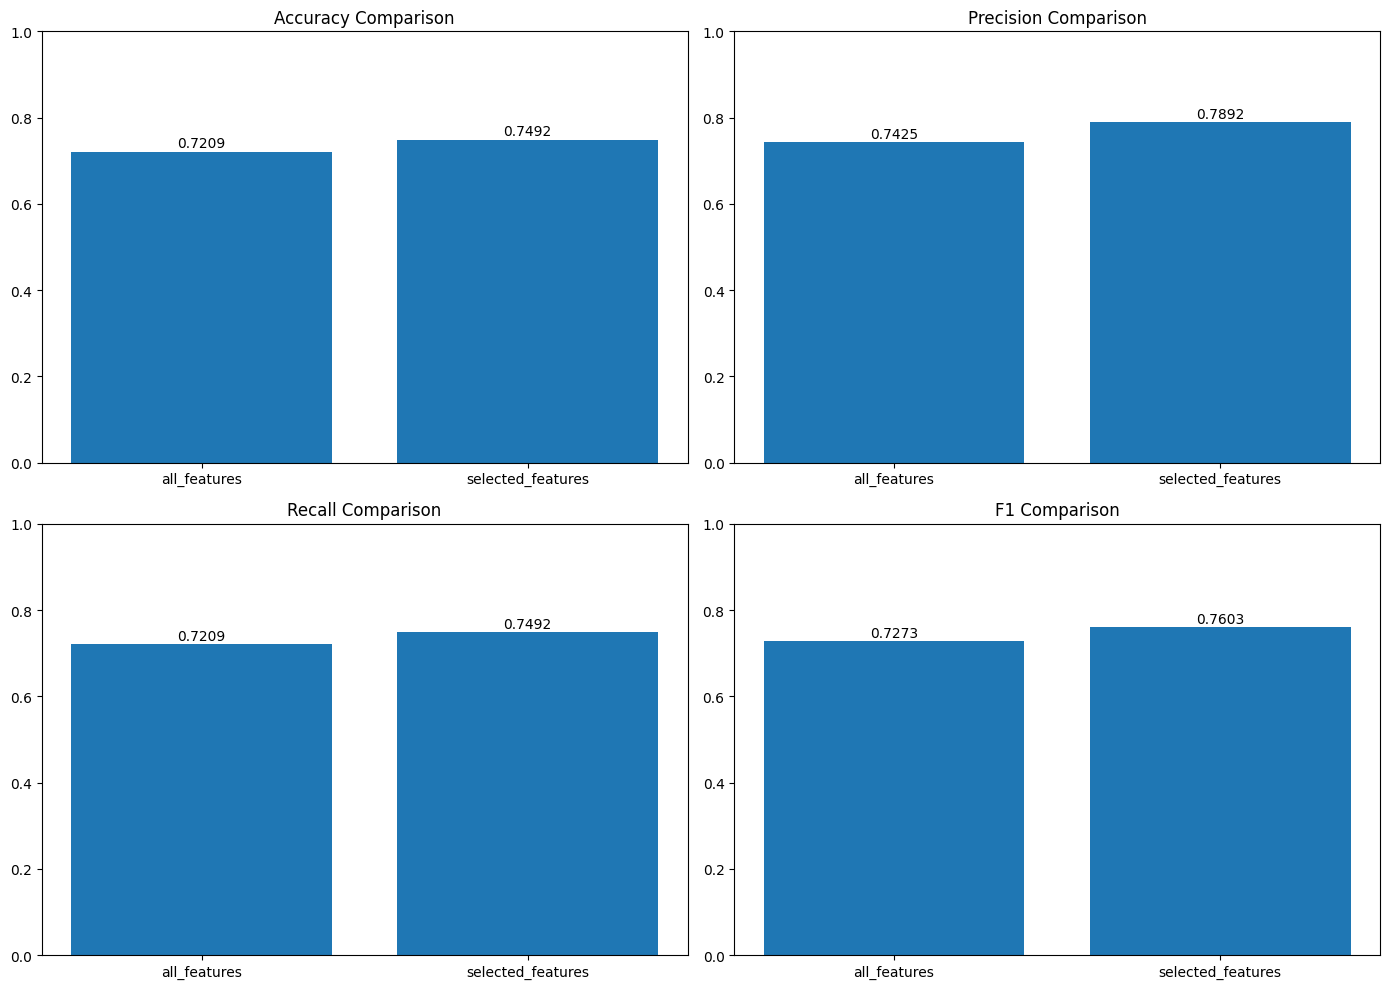

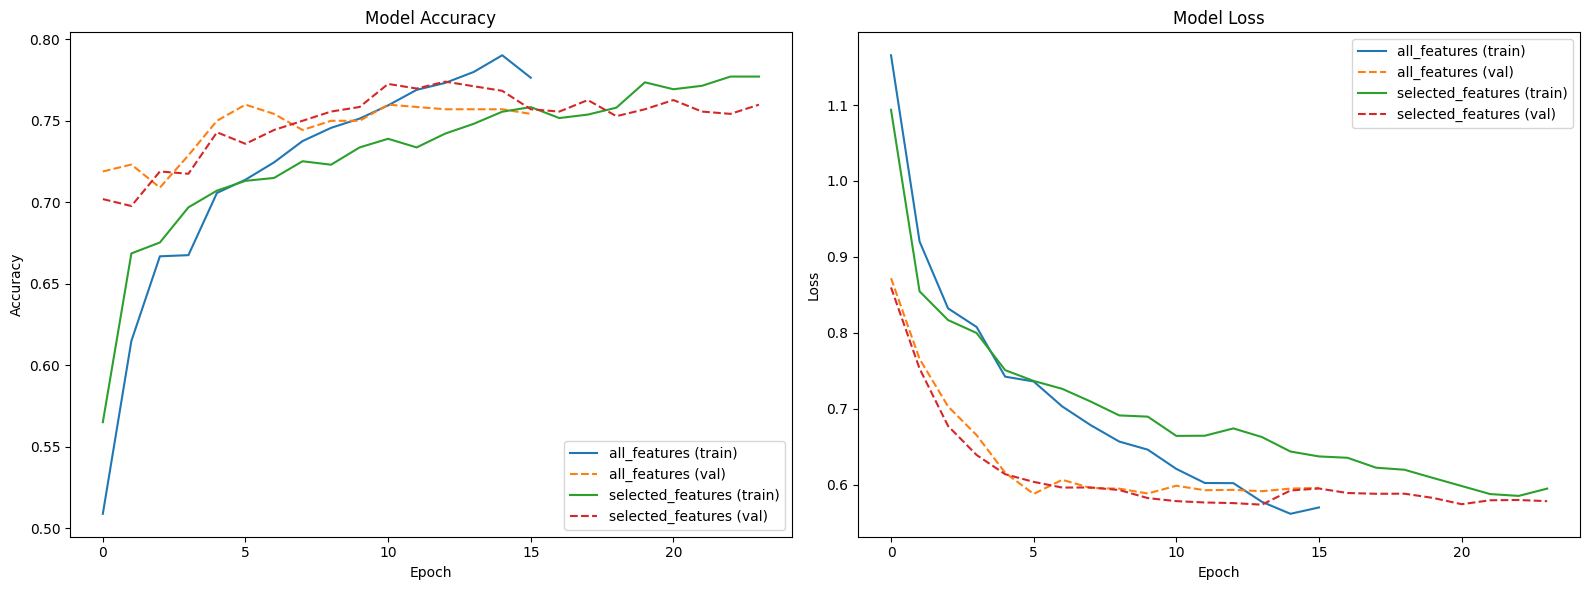

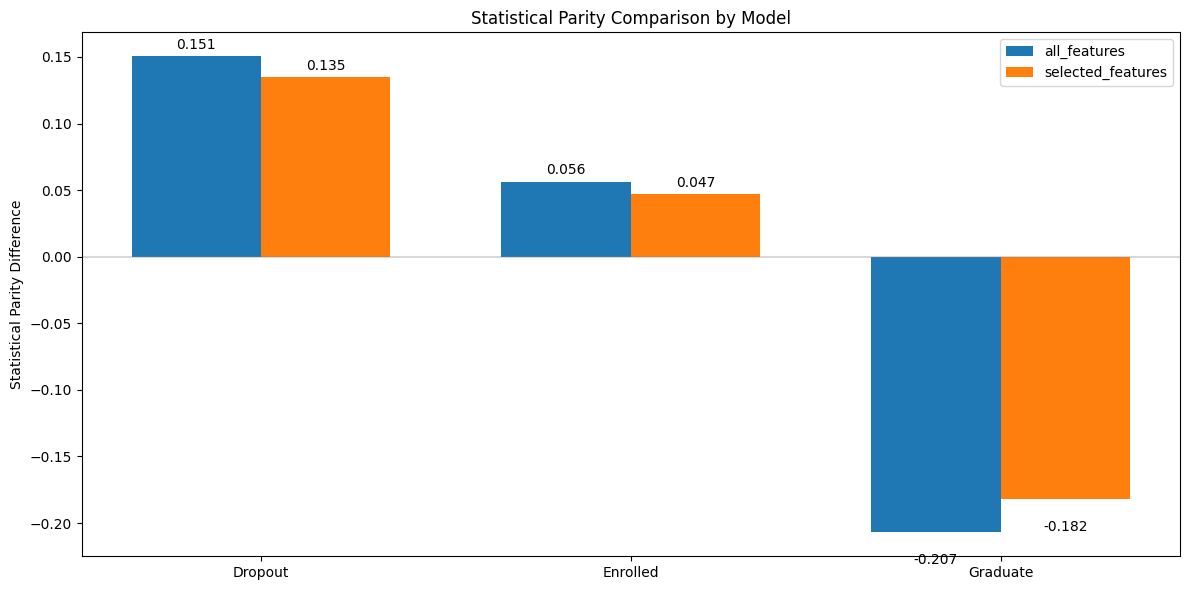

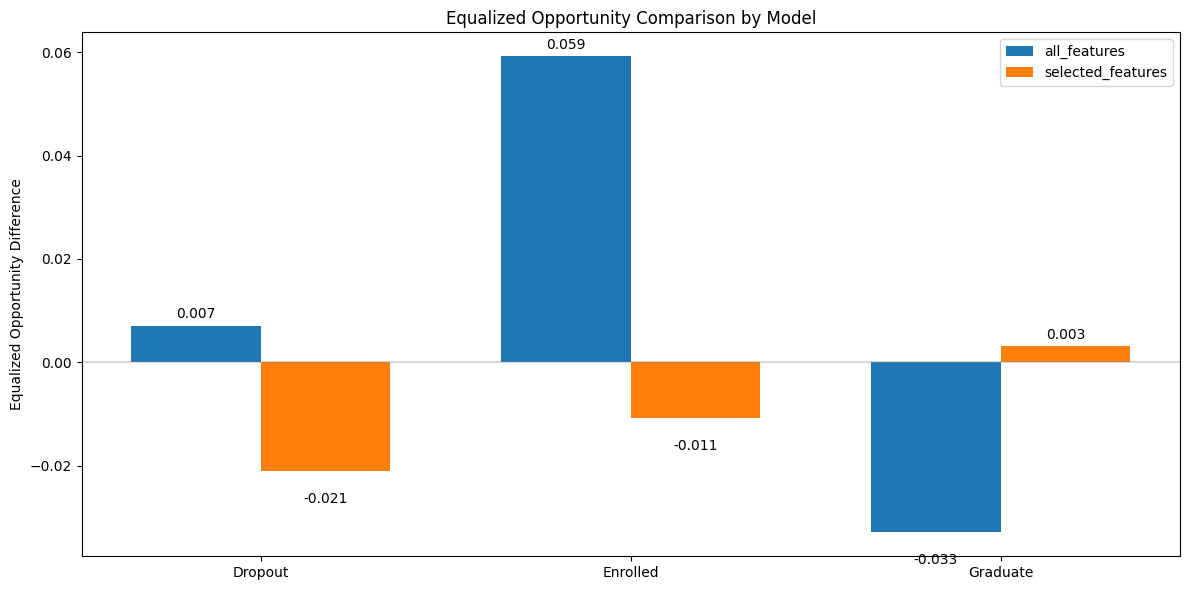

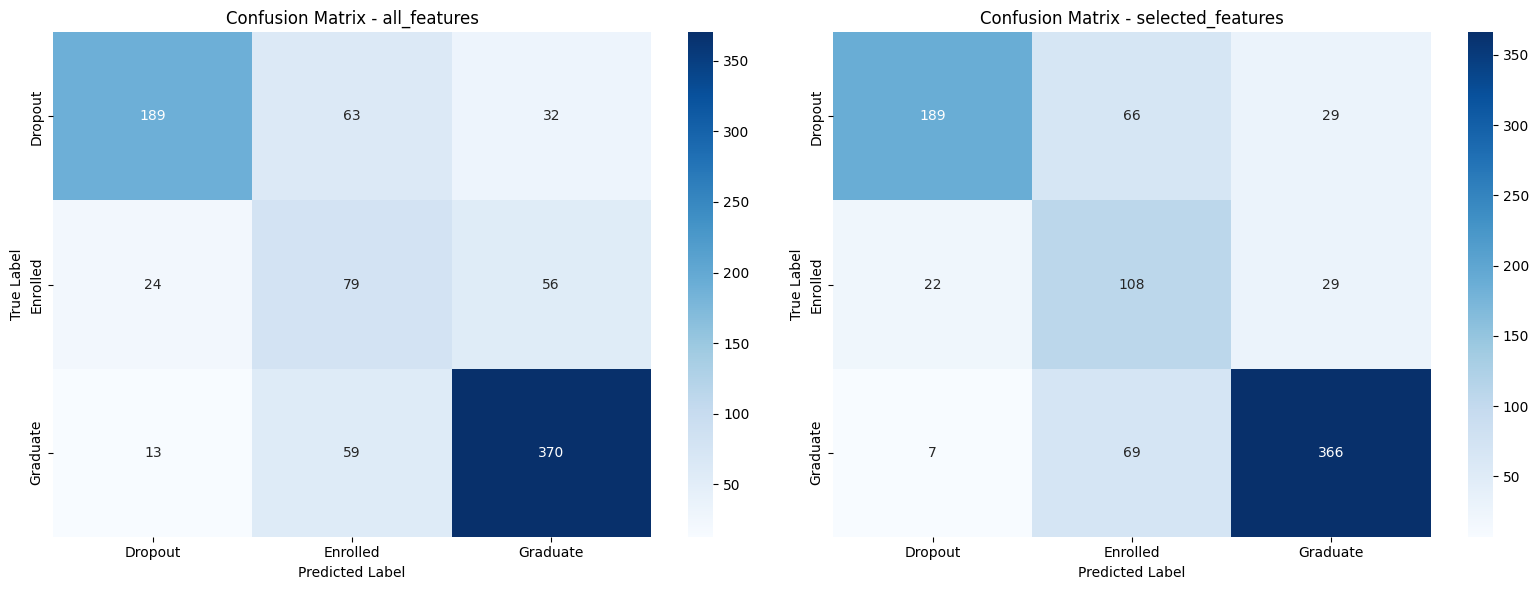


----- MODEL COMPARISON SUMMARY -----

Performance Metrics:

Accuracy:
  all_features: 0.7209
  selected_features: 0.7492

Precision:
  all_features: 0.7425
  selected_features: 0.7892

Recall:
  all_features: 0.7209
  selected_features: 0.7492

F1:
  all_features: 0.7273
  selected_features: 0.7603

Fairness Metrics:

Statistical Parity Difference (ideal = 0):

  Class: Dropout
    all_features: 0.1506
    selected_features: 0.1351

  Class: Enrolled
    all_features: 0.0565
    selected_features: 0.0469

  Class: Graduate
    all_features: -0.2071
    selected_features: -0.1820

Equalized Opportunity Difference (ideal = 0):

  Class: Dropout
    all_features: 0.0071
    selected_features: -0.0211

  Class: Enrolled
    all_features: 0.0592
    selected_features: -0.0108

  Class: Graduate
    all_features: -0.0330
    selected_features: 0.0031

all_features: Used 35 features

selected_features: Used 16 features


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define feature sets
def get_feature_sets():
    # All features
    all_features = {
        'categorical': [
            'Marital status',
            'Application mode',
            'Application order',
            'Course',
            'Previous qualification',
            'Nacionality',
            'Mother\'s qualification',
            'Father\'s qualification',
            'Mother\'s occupation',
            'Father\'s occupation'
        ],
        'binary': [
            'Tuition fees up to date',
            'Displaced',
            'Educational special needs',
            'Debtor',
            'Gender',
            'Scholarship holder',
            'International'
        ],
        'numerical': [
            'Previous qualification (grade)',
            'Admission grade',
            'Age at enrollment',
            'Curricular units 1st sem (credited)',
            'Curricular units 1st sem (enrolled)',
            'Curricular units 1st sem (evaluations)',
            'Curricular units 1st sem (approved)',
            'Curricular units 1st sem (grade)',
            'Curricular units 1st sem (without evaluations)',
            'Curricular units 2nd sem (credited)',
            'Curricular units 2nd sem (enrolled)',
            'Curricular units 2nd sem (evaluations)',
            'Curricular units 2nd sem (approved)',
            'Curricular units 2nd sem (grade)',
            'Curricular units 2nd sem (without evaluations)',
            'Unemployment rate',
            'Inflation rate',
            'GDP'
        ]
    }
    
    # Selected features
    selected_features = {
        'categorical': [
            'Course',
            'Application mode',
            'Mother\'s qualification'
        ],
        'binary': [
            'Tuition fees up to date',
            'Debtor',
            'Scholarship holder'
        ],
        'numerical': [
            'Curricular units 2nd sem (approved)',
            'Curricular units 1st sem (approved)',
            'Curricular units 2nd sem (grade)',
            'Curricular units 2nd sem (evaluations)',
            'Curricular units 1st sem (evaluations)',
            'Curricular units 2nd sem (enrolled)',
            'Admission grade',
            'Curricular units 1st sem (credited)',
            'Previous qualification (grade)',
            'Curricular units 1st sem (grade)'
        ]
    }
    
    return {
        'all_features': all_features,
        'selected_features': selected_features
    }

# Load and prepare data
def load_and_prepare_data(feature_set, df):
    # Combine feature types
    categorical_features = feature_set['categorical']
    binary_features = feature_set['binary']
    numerical_features = feature_set['numerical']
    all_features = categorical_features + binary_features + numerical_features
    
    # Select appropriate columns from dataframe
    X = df[all_features]
    y = df['Target']
    
    # Encode the target
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    y_categorical = to_categorical(y_encoded)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_categorical, test_size=0.2, random_state=42, stratify=y
    )
    
    # Process categorical features
    categorical_encoders = {}
    categorical_dims = {}
    categorical_unique_values = {}
    
    for feature in categorical_features:
        # Handle the issue of unknown classes by encoding on the full dataset
        encoder = LabelEncoder()
        all_values = pd.concat([X_train[feature], X_test[feature]])
        encoder.fit(all_values)
        
        # Transform both train and test
        X_train[feature] = encoder.transform(X_train[feature])
        X_test[feature] = encoder.transform(X_test[feature])
        
        # Store encoder and dimensions
        categorical_encoders[feature] = encoder
        n_unique = len(encoder.classes_)
        categorical_unique_values[feature] = n_unique
        
        # Calculate embedding dimension
        embed_dim = min(50, (n_unique + 1) // 2)
        categorical_dims[feature] = embed_dim
    
    # Scale numerical features
    numerical_scaler = StandardScaler()
    if numerical_features:
        X_train[numerical_features] = numerical_scaler.fit_transform(X_train[numerical_features])
        X_test[numerical_features] = numerical_scaler.transform(X_test[numerical_features])
    
    # Prepare model inputs
    def prepare_model_inputs(X_data):
        model_inputs = []
        
        # Categorical features
        for feature in categorical_features:
            model_inputs.append(X_data[feature].values.reshape(-1, 1))
        
        # Binary features
        for feature in binary_features:
            model_inputs.append(X_data[feature].values.reshape(-1, 1))
        
        # Numerical features (as a single input)
        if numerical_features:
            model_inputs.append(X_data[numerical_features].values)
        
        return model_inputs
    
    train_inputs = prepare_model_inputs(X_train)
    test_inputs = prepare_model_inputs(X_test)
    
    # Calculate class weights
    y_integers = np.argmax(y_train, axis=1)
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_integers),
        y=y_integers
    )
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Return all necessary data
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_inputs': train_inputs,
        'test_inputs': test_inputs,
        'categorical_features': categorical_features,
        'binary_features': binary_features,
        'numerical_features': numerical_features,
        'categorical_encoders': categorical_encoders,
        'categorical_dims': categorical_dims,
        'categorical_unique_values': categorical_unique_values,
        'numerical_scaler': numerical_scaler,
        'label_encoder': label_encoder,
        'class_weights': class_weights_dict,
        'num_classes': num_classes,
        'X_test_index': X_test.index  # For fairness metrics later
    }

# Build model
def build_model(data_dict):
    categorical_features = data_dict['categorical_features']
    binary_features = data_dict['binary_features']
    numerical_features = data_dict['numerical_features']
    categorical_unique_values = data_dict['categorical_unique_values']
    categorical_dims = data_dict['categorical_dims']
    num_classes = data_dict['num_classes']
    
    inputs = []
    embeddings = []
    
    # Process categorical features with embeddings
    for feature in categorical_features:
        input_dim = categorical_unique_values[feature]
        output_dim = categorical_dims[feature]
        
        # Create a valid layer name
        clean_name = feature.replace(' ', '_').replace('\'', '').replace('(', '').replace(')', '').replace('/', '_')
        
        # Input layer for this categorical feature
        inp = Input(shape=(1,), name=f'input_{clean_name}')
        inputs.append(inp)
        
        # Embedding layer
        emb = Embedding(input_dim=input_dim, output_dim=output_dim, 
                       name=f'embedding_{clean_name}')(inp)
        emb = Flatten(name=f'flatten_{clean_name}')(emb)
        embeddings.append(emb)
    
    # Process binary features
    for feature in binary_features:
        clean_name = feature.replace(' ', '_').replace('\'', '').replace('(', '').replace(')', '').replace('/', '_')
        inp = Input(shape=(1,), name=f'input_{clean_name}')
        inputs.append(inp)
        embeddings.append(inp)
    
    # Process numerical features
    if numerical_features:
        numerical_input = Input(shape=(len(numerical_features),), name='input_numerical')
        inputs.append(numerical_input)
        embeddings.append(numerical_input)
    
    # Combine all feature representations
    if len(embeddings) > 1:
        x = Concatenate()(embeddings)
    else:
        x = embeddings[0]
    
    # Deep layers
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train model
def train_model(model, data_dict, model_name):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        data_dict['train_inputs'], 
        data_dict['y_train'],
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        class_weight=data_dict['class_weights'],
        verbose=1
    )
    
    # Load best weights
    model.load_weights(f'best_{model_name}.h5')
    
    return model, history

# Evaluate model
def evaluate_model(model, data_dict, df):
    y_test = data_dict['y_test']
    test_inputs = data_dict['test_inputs']
    label_encoder = data_dict['label_encoder']
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_inputs, y_test, verbose=0)
    
    # Predict classes
    y_pred_prob = model.predict(test_inputs)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Classification report
    class_report = classification_report(y_true, y_pred, 
                                         target_names=label_encoder.classes_,
                                         output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate fairness metrics
    # Extract gender from original dataset using test indices
    gender = df['Gender'].iloc[data_dict['X_test_index']].values
    class_names = label_encoder.classes_
    
    # Statistical Parity Difference (SPD)
    spd_results = {}
    for class_idx, class_name in enumerate(class_names):
        privileged_selection = np.mean(y_pred[gender == 1] == class_idx)
        unprivileged_selection = np.mean(y_pred[gender == 0] == class_idx)
        spd = privileged_selection - unprivileged_selection
        
        spd_results[class_name] = {
            'privileged_selection_rate': privileged_selection,
            'unprivileged_selection_rate': unprivileged_selection,
            'statistical_parity_difference': spd
        }
    
    # Equalized Opportunity (EO)
    eo_results = {}
    for class_idx, class_name in enumerate(class_names):
        y_true_binary = (y_true == class_idx)
        y_pred_binary = (y_pred == class_idx)
        
        privileged_mask = (gender == 1) & y_true_binary
        if np.sum(privileged_mask) > 0:
            privileged_tpr = np.sum(y_pred_binary[privileged_mask]) / np.sum(privileged_mask)
        else:
            privileged_tpr = 0
        
        unprivileged_mask = (gender == 0) & y_true_binary
        if np.sum(unprivileged_mask) > 0:
            unprivileged_tpr = np.sum(y_pred_binary[unprivileged_mask]) / np.sum(unprivileged_mask)
        else:
            unprivileged_tpr = 0
        
        eo = privileged_tpr - unprivileged_tpr
        
        eo_results[class_name] = {
            'privileged_tpr': privileged_tpr,
            'unprivileged_tpr': unprivileged_tpr,
            'equalized_opportunity_difference': eo
        }
    
    # Return all evaluation metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_true': y_true,
        'statistical_parity': spd_results,
        'equalized_opportunity': eo_results
    }

# Visualize results
def plot_results(results_dict, histories):
    models = list(results_dict.keys())
    
    # Performance metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        values = [results_dict[model][metric] for model in models]
        axes[i].bar(models, values)
        axes[i].set_title(f'{metric.capitalize()} Comparison')
        axes[i].set_ylim(0, 1)
        
        # Add value labels
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png')
    plt.show()
    
    # Learning curves comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy
    for model in models:
        axes[0].plot(histories[model].history['accuracy'], label=f'{model} (train)')
        axes[0].plot(histories[model].history['val_accuracy'], label=f'{model} (val)', linestyle='--')
    
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    
    # Loss
    for model in models:
        axes[1].plot(histories[model].history['loss'], label=f'{model} (train)')
        axes[1].plot(histories[model].history['val_loss'], label=f'{model} (val)', linestyle='--')
    
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()
    
    # Fairness metrics comparison
    class_names = list(results_dict[models[0]]['statistical_parity'].keys())
    
    # Statistical Parity
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.35
    
    spd_values = {}
    for model in models:
        spd_values[model] = [results_dict[model]['statistical_parity'][class_name]['statistical_parity_difference'] 
                             for class_name in class_names]
    
    for i, model in enumerate(models):
        offset = width * (i - 0.5)
        rects = ax.bar(x + offset, spd_values[model], width, label=model)
        
        # Add value labels
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3 if height >= 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height >= 0 else 'top')
    
    ax.set_ylabel('Statistical Parity Difference')
    ax.set_title('Statistical Parity Comparison by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('statistical_parity_comparison.png')
    plt.show()
    
    # Equalized Opportunity
    fig, ax = plt.subplots(figsize=(12, 6))
    
    eo_values = {}
    for model in models:
        eo_values[model] = [results_dict[model]['equalized_opportunity'][class_name]['equalized_opportunity_difference'] 
                             for class_name in class_names]
    
    for i, model in enumerate(models):
        offset = width * (i - 0.5)
        rects = ax.bar(x + offset, eo_values[model], width, label=model)
        
        # Add value labels
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3 if height >= 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height >= 0 else 'top')
    
    ax.set_ylabel('Equalized Opportunity Difference')
    ax.set_title('Equalized Opportunity Comparison by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('equalized_opportunity_comparison.png')
    plt.show()
    
    # Confusion matrices
    fig, axes = plt.subplots(1, len(models), figsize=(16, 6))
    if len(models) == 1:
        axes = [axes]
    
    for i, model in enumerate(models):
        cm = results_dict[model]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=class_names,
                  yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {model}')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# Print summary of results
def print_summary(results_dict):
    models = list(results_dict.keys())
    
    print("\n----- MODEL COMPARISON SUMMARY -----")
    
    # Performance metrics
    print("\nPerformance Metrics:")
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metrics:
        print(f"\n{metric.capitalize()}:")
        for model in models:
            print(f"  {model}: {results_dict[model][metric]:.4f}")
    
    # Fairness metrics
    print("\nFairness Metrics:")
    
    class_names = list(results_dict[models[0]]['statistical_parity'].keys())
    
    print("\nStatistical Parity Difference (ideal = 0):")
    for class_name in class_names:
        print(f"\n  Class: {class_name}")
        for model in models:
            spd = results_dict[model]['statistical_parity'][class_name]['statistical_parity_difference']
            print(f"    {model}: {spd:.4f}")
    
    print("\nEqualized Opportunity Difference (ideal = 0):")
    for class_name in class_names:
        print(f"\n  Class: {class_name}")
        for model in models:
            eo = results_dict[model]['equalized_opportunity'][class_name]['equalized_opportunity_difference']
            print(f"    {model}: {eo:.4f}")
    
    # Model details
    for model in models:
        if model == 'all_features':
            feature_count = (
                len(data_dicts['all_features']['categorical_features']) +
                len(data_dicts['all_features']['binary_features']) +
                len(data_dicts['all_features']['numerical_features'])
            )
            print(f"\n{model}: Used {feature_count} features")
        elif model == 'selected_features':
            feature_count = (
                len(data_dicts['selected_features']['categorical_features']) +
                len(data_dicts['selected_features']['binary_features']) +
                len(data_dicts['selected_features']['numerical_features'])
            )
            print(f"\n{model}: Used {feature_count} features")

# Main execution
from sklearn.utils import class_weight

# Load dataset
df = pd.read_csv('data.csv', sep=';')
print(f"Dataset shape: {df.shape}")

# Get feature sets
feature_sets = get_feature_sets()

# Dictionary to store data for each model
data_dicts = {}
models = {}
histories = {}
results = {}

# Process both feature sets
for name, feature_set in feature_sets.items():
    print(f"\nProcessing {name}...")
    
    # Prepare data
    data_dicts[name] = load_and_prepare_data(feature_set, df)
    
    # Build model
    models[name] = build_model(data_dicts[name])
    
    # Train model
    models[name], histories[name] = train_model(models[name], data_dicts[name], name)
    
    # Evaluate model
    results[name] = evaluate_model(models[name], data_dicts[name], df)
    
    # Print basic results
    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"F1 Score: {results[name]['f1']:.4f}")

# Visualize and compare results
plot_results(results, histories)

# Print comprehensive summary
print_summary(results)

# Results dictionary now contains all model results, metrics, and comparisons
# You can access any specific metric for comparison, e.g.:
# print(results['all_features']['accuracy'] vs results['selected_features']['accuracy'])